# Clustering Algorithms: K-means

In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set() # for plot styling
import matplotlib.pyplot as plt

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:
- The 'cluster center' is the arithmetic mean of all points belonging to the cluster
- Each point is closer to its own cluster center than to other cluster centers.

Those assumptions are the basis of the k-mean model.
### A simple example

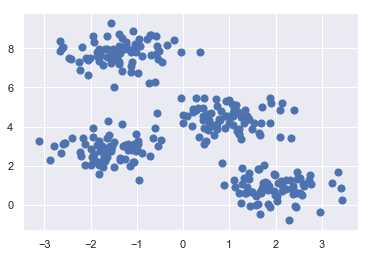

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically.

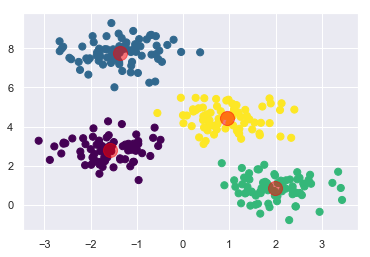

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

### How does k-means work? Expectation Maximization

Expectation-maximization (E-M) is a powerful algoruthm that comes up in a variety of contexts within data science.
1. Guess some cluster centers
2. Repeat until converged
    1. E-Step: assign points to the nearest cluster center
    2. M-Step: set the cluster centers to the mean
Here the E-step or the expectation step is so-named because it envolves updating our expectation of which cluster each point belongs to. The M-step of the 'maximization step' is so-named because it involves maximizing some fitness function tht defines the location of the cluster centers.
The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

## Caveats of E-M
1. No assurance that it will lead to the global best solution
2. Number of clusters must be selected beforehand (can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the sklearn.cluster submodule)
3. Limited to linear cluster boundaries (the algorithm will often be ineffective if the clusters have complicated geometries)
4. Can be slow for large numbers of samples

# Examples
## 1: On digits

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
print(kmeans.cluster_centers_.shape)

(10, 64)


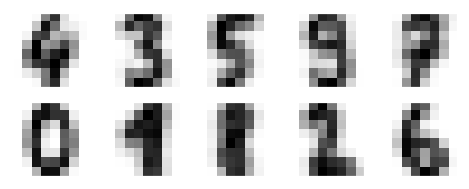

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(8,3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Even without labels, Kmeans is able to find clusters whose centers are recognizable digits with the exception of 1 and 8.
Because k-means knows nothing about the identity of the cluster, the 0-9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [12]:
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

Text(89.18, 0.5, 'predicted label')

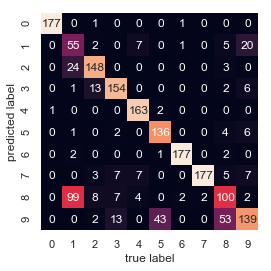

In [14]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=digits.target_names,
           yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Example 2: k-means for color compression
One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

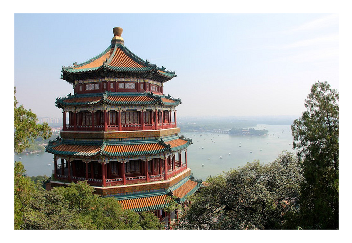

In [16]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

The image is stored in a 3D array (height, width, RGB)

In [17]:
china.shape

(427, 640, 3)

In [19]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [23]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R,G,B = data[i].T
    
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    ax[0].scatter(R,G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0,1), ylim=(0,1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0,1), ylim=(0,1))
    
    fig.suptitle(title, size=20)

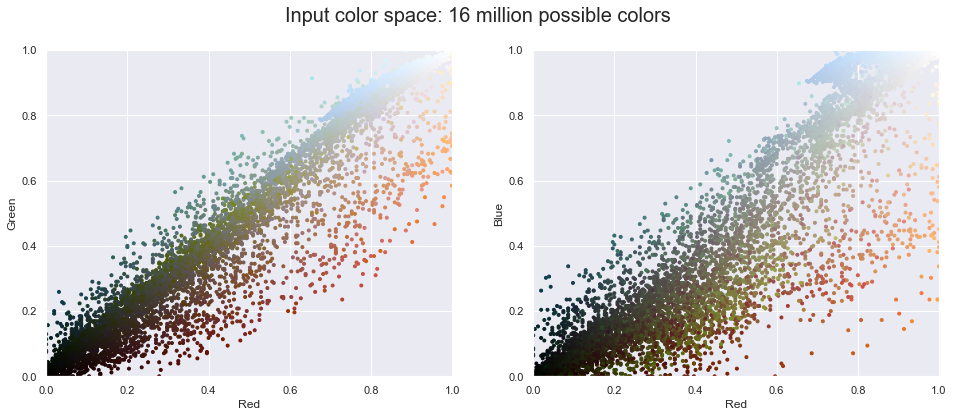

In [24]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now lets reduce these 16M color to 16 colors using a k-means clustering accross the pixel space. We will use the mini batch k-means which operates on subsets of the data to compute the results much more quickly than the standart k-means algorithm

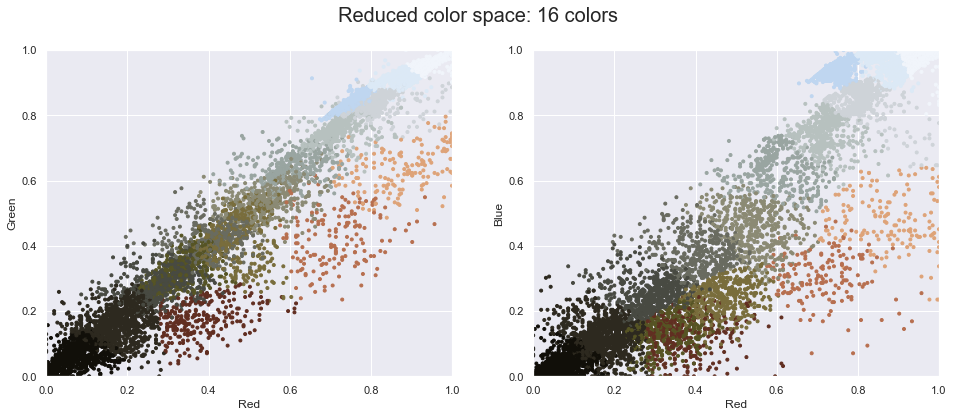

In [25]:
import warnings; warnings.simplefilter('ignore') # fix numpy issues
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, colors=new_colors, title='Reduced color space: 16 colors')

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

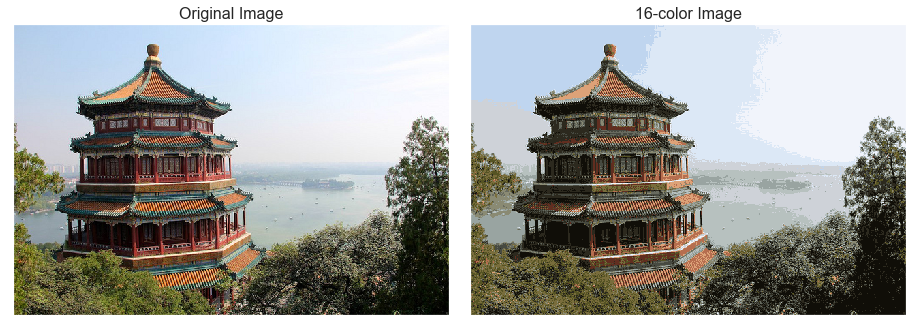

In [26]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.